# Potato Disease Classification

## 1.Problem

> We are trying to detect disease in potato, specifically the early and the late blight disease in potato which are causing economic harm to potato farmers.

## 2. Data

> The data we are using has been provided by the kaggle website under the Plant Village Dataset. It has various other datasets on it but we are only using the potato datasets here.

Link -> https://www.kaggle.com/arjuntejaswi/plant-village

## 3. Evaluation

> We will be training the model on the training dataset and evaluating it on the test dataset.

## 4. Features

* Dealing with images of potatos(unstructured data). Deep learning(CNN) is used.

* There are three categories which are early blight, late blight and healthy potato.

* There are ~1000 diseased potato images for both and ~150 for healthy potatos.

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

## Constants

In [ ]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=50

## Importing the dataset

In [ ]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Colab Notebooks/Dataset",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    )

Found 2152 files belonging to 3 classes.


In [ ]:
class_names=dataset.class_names

In [ ]:
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [ ]:
len(dataset) # Since there are 2151 images and batch size of 32. So 2151/32= 67.25, rounded to 68

68

In [ ]:
for image_batch, label_batch in dataset.take(1):
  print(image_batch.shape)
  print(label_batch.numpy()) # 3 classes so 0,1,2.

(32, 256, 256, 3)
[1 1 0 0 1 0 0 0 0 1 1 2 0 1 0 0 0 1 1 2 1 1 1 1 1 0 0 1 0 1 0 0]


## Visualizing the images

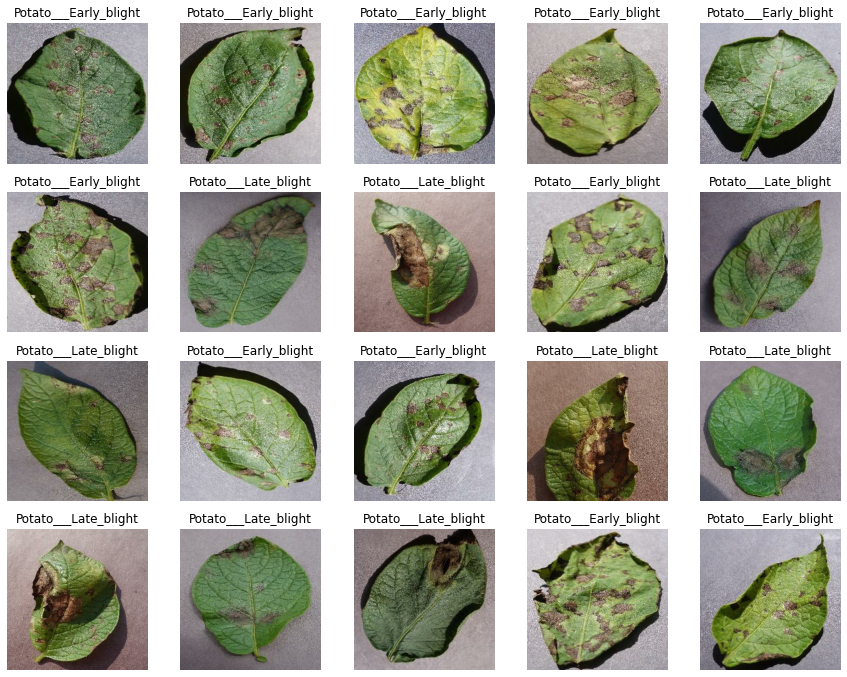

In [ ]:
plt.figure(figsize=(15,15))
for image_batch, label_batch in dataset.take(1):
  for i in range(20):
    ax=plt.subplot(5,5,i+1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    plt.title(class_names[label_batch[i]])
    plt.axis('off') # Image is random as we have 'shuffle=True'

## Splitting the dataset

* 80% will be the training set
* 20% will be the validation and the test set combined

  * 10% will be the validation set
  * 10% will be the test set

In [ ]:
train_size=0.8

In [ ]:
len(dataset)

68

In [ ]:
len(dataset)* train_size

54.400000000000006

In [ ]:
train_ds= dataset.take(54) # Taking the first 54 batches out of the 68 in total. arr[:54]
train_ds

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
len(train_ds)

54

In [ ]:
len(dataset) * 0.2

13.600000000000001

In [ ]:
rest_ds=dataset.skip(54) # Skipping the first 54 batches and getting the rest of the datasets. arr[54:]

In [ ]:
len(rest_ds)

14

In [ ]:
val_size=0.1
len(dataset)* val_size

6.800000000000001

In [ ]:
val_ds=rest_ds.take(6)
len(val_ds)

6

In [ ]:
test_ds=rest_ds.skip(6)
len(test_ds)

8

### Dataset splits

In [ ]:
len(train_ds), len(val_ds), len(test_ds)

(54, 6, 8)

In [ ]:
54+6+8

68

### Function to dynamically split the datasets

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size) 
    rest_ds= ds.skip(train_size)
    val_ds = rest_ds.take(val_size)
    test_ds = rest_ds.skip(val_size)
    
    return train_ds, val_ds, test_ds



In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

#### Splitting the datasets

In [ ]:
len(train_ds), len(val_ds), len(test_ds)

(54, 6, 8)

## Increasing performance of training the model

> We are using `Prefetch() and cache()` to optimize the time required to train the model

In [ ]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Resize and Scaling

> We will be providing them to the last/final iteration of the model, when it is predicting on images so that it gets the right size of the supplied images and the scalling of the images is same as when it was training on the training dataset images.

In [ ]:
resize_AND_rescale= tf.keras.Sequential([
        layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
        layers.Rescaling(1.0/255)
])

## Data Augmentation

> It is used to increase the size of the dataset and create variation of the same image and the performance of predicting if the potato is healthy or has some disease also increases. 

> This will also be used in the last/final iteration of the model.

In [ ]:
data_augmentation=tf.keras.Sequential([
           layers.RandomFlip('horizontal_and_vertical'),
           layers.RandomRotation(0.2),                            
])

## Building the model

> We are building a CNN model for training on the Potato Image dataset.

In [ ]:
input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes=3

cnn= models.Sequential([
                          resize_AND_rescale,
                          data_augmentation,
                          layers.Conv2D(32,(3,3), activation='relu', input_shape=input_shape),
                          layers.MaxPooling2D((2,2)),
                          layers.Conv2D(64,(3,3), activation='relu'),
                          layers.MaxPooling2D((2,2)),
                          layers.Conv2D(64,(3,3), activation='relu'),
                          layers.MaxPooling2D((2,2)),
                          layers.Conv2D(64,(3,3), activation='relu'),
                          layers.MaxPooling2D((2,2)),
                          layers.Conv2D(64,(3,3), activation='relu'),
                          layers.MaxPooling2D((2,2)),
                          layers.Conv2D(64,(3,3), activation='relu'),
                          layers.MaxPooling2D((2,2)),
                          layers.Flatten(),
                          layers.Dense(64, activation='relu'),
                          layers.Dense(n_classes, activation='softmax'),

])

cnn.build(input_shape=input_shape)

In [ ]:
cnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [ ]:
cnn.compile(optimizer='adam', 
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
            metrics=['accuracy']
)

In [ ]:
%%time
history=cnn.fit(train_ds,
                epochs=EPOCHS,
                batch_size=BATCH_SIZE,
                verbose=True,
                validation_data=val_ds
                )

Epoch 1/50
54/54 [==============================] - 553s 239ms/step - loss: 0.9328 - accuracy: 0.4705 - val_loss: 0.9367 - val_accuracy: 0.4323
Epoch 2/50
54/54 [==============================] - 7s 134ms/step - loss: 0.8413 - accuracy: 0.5718 - val_loss: 0.9821 - val_accuracy: 0.5104
Epoch 3/50
54/54 [==============================] - 7s 135ms/step - loss: 0.5873 - accuracy: 0.7610 - val_loss: 0.4639 - val_accuracy: 0.8125
Epoch 4/50
54/54 [==============================] - 7s 135ms/step - loss: 0.4756 - accuracy: 0.8021 - val_loss: 0.5439 - val_accuracy: 0.7865
Epoch 5/50
54/54 [==============================] - 7s 135ms/step - loss: 0.3866 - accuracy: 0.8553 - val_loss: 0.6052 - val_accuracy: 0.7552
Epoch 6/50
54/54 [==============================] - 7s 135ms/step - loss: 0.3022 - accuracy: 0.8796 - val_loss: 0.4114 - val_accuracy: 0.8073
Epoch 7/50
54/54 [==============================] - 7s 135ms/step - loss: 0.2924 - accuracy: 0.8866 - val_loss: 0.2767 - val_accuracy: 0.8958
Epoc

In [ ]:
scores=cnn.evaluate(test_ds)

8/8 [==============================] - 6s 60ms/step - loss: 0.1344 - accuracy: 0.9531


In [ ]:
scores

[0.13435539603233337, 0.953125]

In [ ]:
history

In [ ]:
history.params

{'epochs': 50, 'steps': 54, 'verbose': True}

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history.history['loss']

[0.9328041076660156,
 0.8412740230560303,
 0.5873275995254517,
 0.47564584016799927,
 0.3865847885608673,
 0.3021681606769562,
 0.2923817038536072,
 0.2179415374994278,
 0.21788565814495087,
 0.183133065700531,
 0.14772170782089233,
 0.15441440045833588,
 0.10407385230064392,
 0.150939479470253,
 0.10901409387588501,
 0.161581888794899,
 0.08255668729543686,
 0.08790040761232376,
 0.0718197152018547,
 0.07564979046583176,
 0.09306679666042328,
 0.059880416840314865,
 0.09841728210449219,
 0.054689448326826096,
 0.05599987879395485,
 0.0830334797501564,
 0.04819142073392868,
 0.09980040043592453,
 0.037889935076236725,
 0.06725011765956879,
 0.03960182145237923,
 0.0676920935511589,
 0.03745270147919655,
 0.06537255644798279,
 0.022545238956809044,
 0.03896082192659378,
 0.06191818043589592,
 0.03770267590880394,
 0.04611009731888771,
 0.022361543029546738,
 0.022488197311758995,
 0.051477450877428055,
 0.04544723778963089,
 0.032294340431690216,
 0.01821383833885193,
 0.028620131313800

In [ ]:
len(history.history['loss'])

50

## Plotting the values 

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

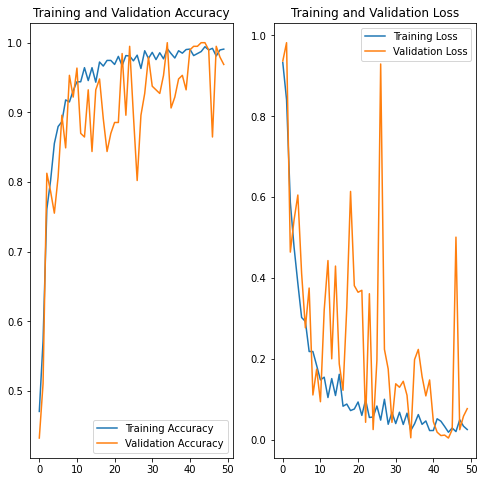

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Visualizing the predictions

first image to predict
Actual label: Potato___Early_blight
Predicted label: Potato___Early_blight


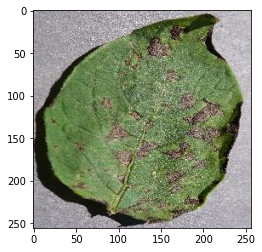

In [ ]:
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    # Actual/True Label
    
    print("first image to predict")
    plt.imshow(first_image)
    print("Actual label:",class_names[first_label])

    # Predicted Label by model
    
    batch_prediction = cnn.predict(images_batch)
    print("Predicted label:",class_names[np.argmax(batch_prediction[0])])

## Prediction

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Creating a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

### Making predictions on the trained model

In [57]:
plt.figure(figsize=(30, 35))
for images, labels in test_ds.take(1):
    for i in range(32):
        ax = plt.subplot(6, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(cnn, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

Output hidden; open in https://colab.research.google.com to view.

## Saving the Model

In [58]:
model_version=1
cnn.save(f'/content/drive/MyDrive/Colab Notebooks/models/{model_version}')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/models/1/assets


In [60]:
import os
os.listdir('/content/drive/MyDrive/Colab Notebooks/models')

['1']

In [64]:
model_version=max([int(i) for i in os.listdir('/content/drive/MyDrive/Colab Notebooks/models')+ [0]]) +1
cnn.save(f'/content/drive/MyDrive/Colab Notebooks/models/{model_version}')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/models/3/assets
